# LSTM

기본 순환층은 일반적으로 긴 시퀀스를 학습하기 어렵다.
- 시퀀스가 길어질수록 순환되는 은닉 상태에 담긴 정보가 점차 희석되기 때문
- 따라서 멀리 떨어져 있는 단어 정보를 인식하는 데 어려울 수 있다.
- 이를 위해 LSTM과 GRU 셀이 발명되었다.

## LSTM 구조

LSTM (Long Short-Term Memory)
- 구조가 복잡하지만 기본 개념은 동일하다
    - 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조
    - 이전 은닉 상태를 순환 시키는 것도 동일
    - 여기서 셀 상태 c가 추가적으로 순환됨 (출력되지 않고 셀 내부만 순환한다)
- 기존 셀에 3가지의 작은 셀이 더 추가되어 셀 상태를 만드는 데 기여한다.

구성요소
- 입력($x$), 가중치($w_f, w_i, w_j, w_o$), 셀 상태($c$), 은닉 상태($h$)
- sigmoid, tanh 함수
- 삭제 게이트, 입력 게이트, 출력 게이트

1. 삭제 게이트
    - 셀 상태에 있는 정보를 제거하는 역할
    - $ c = sigmoid((x+h) \times w_f) \times c $

2. 입력 게이트
    - 두 셀이 추가되어 새로운 정보를 셀 상태에 추가하는 역할
    - $ temp = sigmoid((x+h) \times w_i) \times tanh((x+h) \times w_j) $
    - $ c = c + temp $ 

3. 출력 게이트
    - 최종 은닉 상태를 만들어내는 역할
    - $ h = sigmoid((x+h) \times w_o) \times tanh(c) $

## LSTM 신경망 훈련하기

먼저 이전 절에서처럼 데이터를 로드하고 훈련 세트와 검증 세트로 나누자

In [1]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

17473536/17464789 [==============================] - 0s 0us/step


그다음 pad_sequences() 함수를 적용하자

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

모델을 구성하자

SimpleRNN 대신 LSTM 클래스를 사용한다.

In [4]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


기존 SimpleRNN 의 모델 파라미터는 200개였는데, LSTM의 경우엔 미니셀이 4개이므로, 4배인 800개이다.

이제 모델을 컴파일하고 훈련해보자.
- 설정 등 나머지는 다 동일하다.

In [5]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 15s 40ms/step - loss: 0.6929 - accuracy: 0.5249 - val_loss: 0.6924 - val_accuracy: 0.5664
Epoch 2/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6916 - accuracy: 0.5954 - val_loss: 0.6907 - val_accuracy: 0.6242
Epoch 3/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6887 - accuracy: 0.6298 - val_loss: 0.6862 - val_accuracy: 0.6360
Epoch 4/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6792 - accuracy: 0.6330 - val_loss: 0.6659 - val_accuracy: 0.6068
Epoch 5/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6391 - accuracy: 0.6913 - val_loss: 0.6157 - val_accuracy: 0.7288
Epoch 6/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6012 - accuracy: 0.7406 - val_loss: 0.5893 - val_accuracy: 0.7404
Epoch 7/100
313/313 [==============================] - 20s 65ms/step - loss: 0.5812 - accuracy: 0.7460 - val_loss: 0.5732 - val_ac

훈련 손실과 검증 손실 그래프를 그려보자

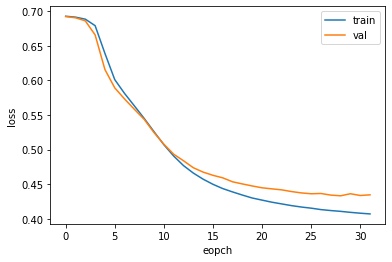

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('eopch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 어느정도 억제되면서 잘 수행되는 것 같다.

하지만 필요에 따라서는, 과대적합을 더 강하게 제어할 필요가 있다.
- 드롭아웃을 순환층에도 적용해보자.

## 순환층에 드롭아웃 적용하기

FC 신경망과 CNN 에서는 Dropout 클래스를 사용해 드롭아웃을 적용했다.

하지만 RNN은 자체적으로 드롭아웃 기능을 제공한다.
- dropout 매개변수: 셀의 입력에 드롭아웃을 적용
- recurrent_dropout 매개변수: 순환되는 은닉 상태에 드롭아웃 적용
    - 단, 기술적 문제로 인해, GPU를 이용하여 모델을 훈련하지 못한다.
    - 이 때문에 모델의 훈련 속도가 크게 느려진다.

다른 모델 구조는 동일하게, LSTM 클래스에 dropout=0.3 으로 지정하여 모델을 다시 구성하고 훈련시켜보자.

In [7]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 15s 42ms/step - loss: 0.6926 - accuracy: 0.5322 - val_loss: 0.6919 - val_accuracy: 0.5802
Epoch 2/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6910 - accuracy: 0.5927 - val_loss: 0.6894 - val_accuracy: 0.6224
Epoch 3/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6871 - accuracy: 0.6237 - val_loss: 0.6831 - val_accuracy: 0.6274
Epoch 4/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6723 - accuracy: 0.6069 - val_loss: 0.6498 - val_accuracy: 0.6164
Epoch 5/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6336 - accuracy: 0.6819 - val_loss: 0.6148 - val_accuracy: 0.7256
Epoch 6/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6030 - accuracy: 0.7396 - val_loss: 0.5902 - val_accuracy: 0.7432
Epoch 7/100
313/313 [==============================] - 13s 41ms/step - loss: 0.5832 - accuracy: 0.7495 - val_loss: 0.5724 - val_ac

검증 손실이 약간 향상되었나? 비슷한디

그래프를 그려보자

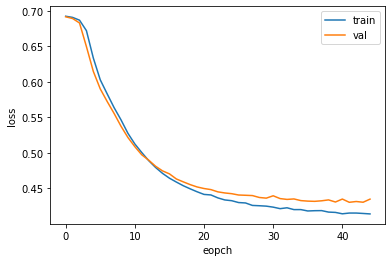

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('eopch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련 손실과 검증 손실 간의 차이가 정말 미세하게 좁혀진 것을 확인할 수 있다.

## 2개의 층을 적용하기

FC 신경망이나 CNN 처럼 여러 순환층을 쌓지 않을 이유가 없다.

단, RNN 에서 마지막을 제외한 다른 모든 순환층에서는 모든 타임스텝의 은닉 상태를 출력해야 한다.
- return_sequences 매개변수를 True로 지정하면 된다.

In [9]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_3 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_4 (LSTM)               (None, 8)                 544       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 31s 82ms/step - loss: 0.6922 - accuracy: 0.5490 - val_loss: 0.6910 - val_accuracy: 0.6020
Epoch 2/100
313/313 [==============================] - 25s 81ms/step - loss: 0.6866 - accuracy: 0.6234 - val_loss: 0.6796 - val_accuracy: 0.6670
Epoch 3/100
313/313 [==============================] - 25s 79ms/step - loss: 0.6517 - accuracy: 0.6798 - val_loss: 0.6065 - val_accuracy: 0.7124
Epoch 4/100
313/313 [==============================] - 25s 80ms/step - loss: 0.5693 - accuracy: 0.7242 - val_loss: 0.5460 - val_accuracy: 0.7388
Epoch 5/100
313/313 [==============================] - 25s 80ms/step - loss: 0.5361 - accuracy: 0.7429 - val_loss: 0.5185 - val_accuracy: 0.7540
Epoch 6/100
313/313 [==============================] - 25s 79ms/step - loss: 0.5127 - accuracy: 0.7620 - val_loss: 0.5012 - val_accuracy: 0.7656
Epoch 7/100
313/313 [==============================] - 25s 79ms/step - loss: 0.4989 - accuracy: 0.7682 - val_loss: 0.4889 - val_ac

훈련 세트와 검증 세트의 손실 차이가 대략 0.020에서 0.012 정도로 줄었다.

일반적으로 순환층을 쌓으면 성능이 높아지지만, 이 예제에서는 큰 효과가 없다.

그래프도 그려보자

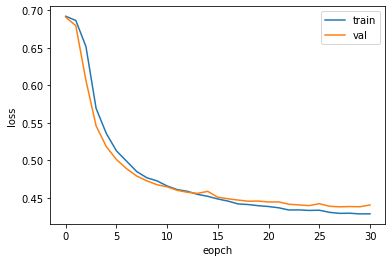

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('eopch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

이렇게 보면 확실히 검증 손실과 훈련 손실의 차이가 많이 좁혀진 것 같다.

다음은 GRU 구조에 대해 알아보자.

# GRU

## GRU 구조

GRU (Gated Recurrent Unit)
- LSTM의 간소화 버전.
    - 셀 상태를 계산하지 않고, 은닉 상태 하나만 포함한다.
- 미니 셀 3개가 포함된다.

구성요소
- 입력($x$), 가중치($w_z, w_r, w_g$), 은닉 상태($h$)
- sigmoid, tanh 함수
- 삭제 게이트, 입력 정보 제어, 은닉 상태 제어

1. 입력 정보 제어
    - $ R = sigmoid((x+h) \times w_r) $

2. 삭제 게이트
    - $ Z = sigmoid((x+h) \times w_z) $

3. 은닉 상태 제어
    - $ G = tanh((x+h×R) \times w_g) × (1 - Z) $

4. 최종 은닉 상태 계산
    - $ h = (h + G) × Z $

## GRU 신경망 훈련하기

In [12]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


GRU 층의 모델 파라미터
- 예상대로라면 3개의 미니 셀이니 600개의 모델 파라미터가 있어야 하는데, 무엇이 잘못되었을까?
- 이는 텐서플로에서는 GPU를 잘 활용하기 위해, 모델의 형태를 약간 변형시켰기 때문

훈련을 시켜보자.

In [13]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 18s 51ms/step - loss: 0.6918 - accuracy: 0.5274 - val_loss: 0.6905 - val_accuracy: 0.5596
Epoch 2/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6890 - accuracy: 0.5644 - val_loss: 0.6873 - val_accuracy: 0.5772
Epoch 3/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6847 - accuracy: 0.5904 - val_loss: 0.6825 - val_accuracy: 0.5916
Epoch 4/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6783 - accuracy: 0.6072 - val_loss: 0.6754 - val_accuracy: 0.6030
Epoch 5/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6687 - accuracy: 0.6243 - val_loss: 0.6651 - val_accuracy: 0.6164
Epoch 6/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6547 - accuracy: 0.6399 - val_loss: 0.6498 - val_accuracy: 0.6316
Epoch 7/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6342 - accuracy: 0.6575 - val_loss: 0.6275 - val_ac

그래프도 그려보자

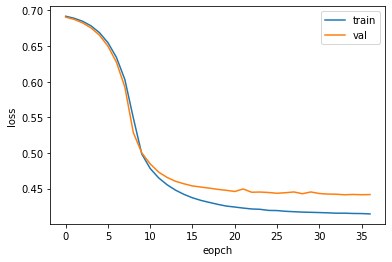

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('eopch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

드롭아웃이나 2중층이 아니어서 성능이 약간 떨어져 보이지만 만족만족 대만족!

# 마무리

마지막으로 가장 성능이 좋았던 2개의 순환층을 쌓은 모델을 로드하여 테스트 세트에 대한 성능을 확인해보자.
- 테스트 세트를 훈련/검증 세트와 같은 방식으로 변환하고
- load_model() 함수를 이용하여 best-2rnn.model.h5 파일을 읽고
- evaluate() 함수로 성능을 계산하자.

In [15]:
test_seq = pad_sequences(test_input, maxlen=100)
rnn_model = keras.models.load_model('best-2rnn-model.h5')
rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 11s 13ms/step - loss: 0.4341 - accuracy: 0.7973


[0.43406882882118225, 0.7973200082778931]

정확도 79.73% 

훈련 세트 정확도 80.66%, 검증 세트 정확도 79.76%와 크게 차이나지 않는 훌륭한 성능을 보여주었다.

끝!